In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd
import json

In [2]:
# Packages for dataviz
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go
import cufflinks as cf
import matplotlib.pyplot as plt

In [3]:
# configuration for plotly
template = "plotly_dark"

# offline configuration of cufflinks
cf.go_offline()

In [4]:
pd.set_option('display.max_columns', 110)

In [5]:
# Load the data
data = pd.read_csv('../data/clean.csv')

with open('../data/meta_data.json') as json_file:
    meta = json.load(json_file)

In [6]:
meta['y']
data.head()

,review_scores_rating,accommodates,guests_included,availability_365,number_of_reviews_ltm,minimum_nights_avg_ntm,maximum_nights_avg_ntm,bathrooms,bedrooms,beds,price,extra_people,security_deposit,cleaning_fee,host_response_rate,maximum_nights,minimum_nights,city,property_type,room_type,bed_type,cancellation_policy,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_is_superhost,host_has_profile_pic,host_identity_verified,zipcode,latitude,longitude,neighbourhood_cleansed
0,97.0,3,2,85,52,1,30,1.0,1.0,2.0,170,25,100.0,100.0,100.0,30,1,San Francisco,Apartment,Entire home/apt,Real Bed,moderate,True,True,False,False,False,True,True,True,94117,37.76931,-122.43386,Western Addition
1,94.0,2,2,62,36,1,5,1.0,1.0,1.0,99,20,0.0,10.0,100.0,5,1,San Francisco,House,Private room,Real Bed,strict_14_with_grace_period,True,True,False,False,False,True,True,True,94131,37.75402,-122.45805,Inner Sunset
2,98.0,5,2,0,0,30,60,1.0,2.0,3.0,235,0,NaN,100.0,80.0,60,30,San Francisco,Apartment,Entire home/apt,Real Bed,strict_14_with_grace_period,True,True,False,False,False,False,True,True,94110,37.74511,-122.42102,Bernal Heights
3,86.0,2,1,365,1,32,60,4.0,1.0,1.0,65,12,200.0,50.0,86.0,60,32,San Francisco,Apartment,Private room,Real Bed,strict_14_with_grace_period,True,True,False,False,False,True,True,True,94117,37.76669,-122.45250,Haight Ashbury
4,93.0,2,1,365,0,32,90,4.0,1.0,1.0,65,12,200.0,50.0,86.0,90,32,San Francisco,Apartment,Private room,Real Bed,strict_14_with_grace_period,True,True,False,False,False,True,True,True,94117,37.76487,-122.45183,Haight Ashbury


# 1. Modification des variables

## 1.1 Discretisation de Y

Le prof veut qu'on fasse de la clssification et pas de la regression, il faut choisir les categories de la variable Y

In [7]:
px.histogram(data, x = meta['y'], marginal="box", template = template).show()

On peut couper selon le 1er quartil et la moyenne. Cela permet de distribuer les valeurs de manière à peu près homogène. 

In [8]:
y_cat = pd.cut(data[meta['y']], bins=[0, 95, 98, 100], labels=['bad', 'good', 'excellent'])

In [9]:
print(y_cat.value_counts())

excellent    2625
bad          1979
good         1848
Name: review_scores_rating, dtype: int64


In [10]:
data[meta['y']] = y_cat

## 1.2 Traitement des donnees geospatiales

Pour les donnees geospatiales, on propose de diviser les quartiers (neighbourhoods_cleansed) en trois categories (good, neutral, bad). On preconise que le l'indicateur qui aura le plus grand impact sur la perception de la qualité des appartements, directement et indirectement, sera le taux de criminalite dans le quartier. Donnees tirees de https://www.areavibes.com/san+francisco-ca/crime/

Selon le score de criminalite de chaque quartier, attribue un score 0, 1, 2.

F a D- : 2
D a B- : 1
B a A+ : 0

On ajoute une colonne 'crime' aux données, qui attribue ce score 0/1/2.

In [11]:
#Ajout d'une colonne 'crime'

neighbourhood_crime=[['Bayview', 'Bernal Heights', 'Castro-Upper Market', 'Chinatown', 'Diamond Heights', 'Downtown','Haight-Ashbury','Lakeshore', 'Marina', 'Mission', 'Nob Hill', 'Outer Mission', 'Portrero Hill', 'Russian Hill', 'South of Market', 'Visitacion Valley', 'Western Addition'],
                     ['Excelsior', 'Financial District', 'Golden Gate Park', 'Glen Park', 'Inner Richmond', 'North Beach', 'Pacific Heights', 'Parkside', 'Presidio Heights', 'Seacliff', 'Twin Peaks', 'West of Twin Peaks'],
                     ['Crocker Amazon', 'Inner Sunset', 'Noe Valley', 'Ocean View', 'Outer Richmond', 'Outer Sunset', 'Treasure Island']]

data['crime'] = float('nan')
crime_color = []

In [12]:
#Remplissage de la colonne 'crime'

for i in range(len(data)):
    
    if data['neighbourhood_cleansed'][i] in neighbourhood_crime[0]:
        data['crime'][i] = 2
        crime_color.append('maroon')
    
    elif data['neighbourhood_cleansed'][i] in neighbourhood_crime[1]:
        data['crime'][i] = 1
        crime_color.append('darkorange')
    
    elif data['neighbourhood_cleansed'][i] in neighbourhood_crime[2]:
        data['crime'][i] = 0
        crime_color.append('orangered')
    
    else:
        #print('review neighbourhood_crime for missing neighbourhoods')
        crime_color.append('grey')

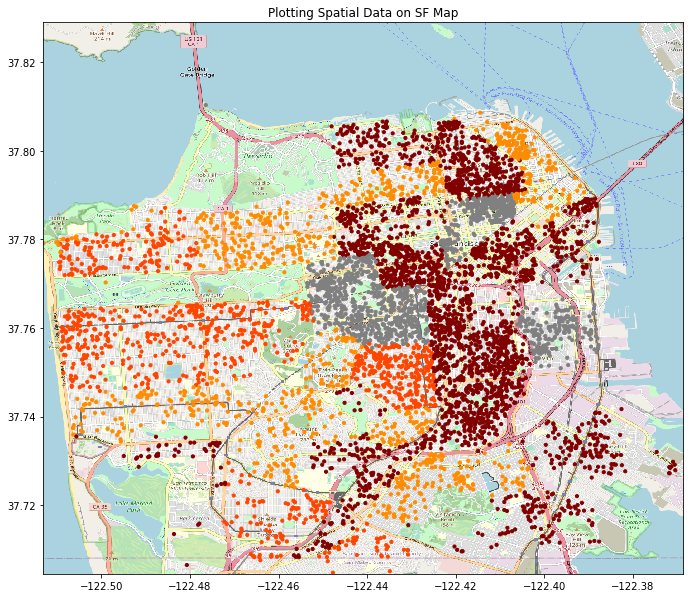

In [13]:
# Visualisation des donnees sur une carte :


#Box = (data.longitude.min(),   data.longitude.max(),      
#        data.latitude.min(), data.latitude.max())
    
Box = (-122.5132, -122.3686,      
       37.7045, 37.8290)

carte = plt.imread("../data/map.png")

fig, ax = plt.subplots(figsize = (11.48,12.48))
ax.scatter(data.longitude, data.latitude, zorder=1, alpha= 1, c=crime_color, s=10)
#ax.scatter(data.longitude, data.latitude, zorder=1, alpha= 1, c='fuchsia', s=10)
ax.set_title('Plotting Spatial Data on SF Map')
ax.set_xlim(Box[0],Box[1])
ax.set_ylim(Box[2],Box[3])
ax.imshow(carte, zorder=0, extent = Box, aspect= 'equal')

#fig.savefig('testeo')

## 1.3 Traitement des variables categoriques

In [14]:
data['property_type'].value_counts()

Apartment             2334
House                 1982
Condominium            716
Guest suite            553
Boutique hotel         175
Hotel                  129
Townhouse              118
Serviced apartment      87
Loft                    82
Hostel                  80
Bed and breakfast       41
Guesthouse              38
Aparthotel              37
Other                   23
Bungalow                15
Cottage                 12
Resort                   9
Villa                    8
Castle                   4
Tiny house               3
Cabin                    2
Earth house              2
In-law                   1
Dome house               1
Name: property_type, dtype: int64

In [15]:
data['property_type'] = data['property_type'].replace(['Serviced apartment', 'Loft'], 'Apartment')

data['property_type'] = data['property_type'].replace(['Boutique hotel', 'Hostel','Aparthotel'], 'Hotel')

data['property_type'] = data['property_type'].replace(['Townhouse', 'Guesthouse', 'Villa'], 'House')

data['property_type'] = data['property_type'].replace(['Bed and breakfast'], 'Guest suite')

data['property_type'] = data['property_type'].replace(['Bungalow', 'Cottage', 'Earth house', 'Cabin', 'In-law',
                                       'Dome house', 'Resort', 'Castle', 'Tiny house'], 'Other')

Il faut verifier les categories que j'ai crée, j'ai des doutes sur certains regroupements, comme par exemple pour **Loft, Aparthotel, ...**

In [16]:
data['city'] = data['city'].replace(['San Francisco, Hayes Valley', 'Noe Valley - San Francisco', 
                                     'San Francisco ', 'Brisbane'], 'San Francisco')

In [17]:
print(data['crime'].isna().sum())
data['crime'].value_counts()

1411


2.0    2915
1.0    1099
0.0    1027
Name: crime, dtype: int64

# 2. Separation entrainement/validation

In [18]:
from sklearn.model_selection import train_test_split

# separate target from predictors
y = data[meta['y']]
X = data.drop(columns = meta['y'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [19]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = ["excellent", "bad", "good"],
    y = y_train.value_counts(),
    name = 'train',
    #marker_color = 'indianred',
))

fig.add_trace(go.Bar(
    x = ["excellent", "bad", "good"],
    y = y_valid.value_counts(),
    name = 'validation',
    #marker_color = 'lightsalmon',
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
#fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

In [20]:
print(y_train.value_counts())
print()
print(y_valid.value_counts())

excellent    2103
bad          1573
good         1485
Name: review_scores_rating, dtype: int64

excellent    522
bad          406
good         363
Name: review_scores_rating, dtype: int64


On constate que les classes sont à peu pres bien reparties dans les ensembles "train" et "validation"

# 3. Preprocessing et entrainement du modele

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


### Trie à faire dans les imports

In [22]:
####### Etudier les SimpleImputer

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy = 'most_frequent')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Preprocessing for boolean data
# boolean_transformer = OrdinalEncoder()


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, meta['quant']),
        ('cat', categorical_transformer, meta['cat'] + meta['bool'] + ['crime'])
        #('bool'), boolean_transformer, meta['bool']
    ])

label = meta['quant'] + meta['cat'] + meta['bool'] + ['crime']

In [23]:
# Define model
model_rf = RandomForestClassifier(n_estimators=100, random_state=0)
model_tree = DecisionTreeClassifier(random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_rf)
                         ])

clf_tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model_tree)
                         ])

# 4. Etude des résultats

In [24]:
# Preprocessing of training data, fit model 
clf_rf.fit(X_train, y_train)
clf_tree.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds_rf = clf_rf.predict(X_valid)
preds_tree = clf_tree.predict(X_valid)

In [25]:
def show_results(name, y_valid, preds):
    
    label = ["bad", "good", "excellent"]
    label_r = label.copy()
    label_r.reverse()
    
    # precision
    print("Accuracy", name, ":", metrics.accuracy_score(y_valid, preds),"\n")

    # matrice de confusion
    m = metrics.confusion_matrix(y_valid, preds, labels = label)
    #print("Confusion matrix", name, ":\n%s" % m)
    
    # heatmap
    h = []
    for elt in reversed(m):
        h.append(elt)
    
    go.Figure(data=go.Heatmap(
                       z = h,
                       x = label,
                       y = label_r,
                       colorscale = "oryel")
             ).show()

## 4.1 Accuracy et matrice de confusion

In [26]:
show_results("random forest", y_valid, preds_rf)

Accuracy random forest : 0.570875290472502 



In [27]:
show_results("classification tree", y_valid, preds_tree)

Accuracy classification tree : 0.4701781564678544 



## 4.2 Importance des variables

In [28]:
# etude de l'importance des variables
imp_tree = clf_tree.steps[1][1].feature_importances_
imp_rf = clf_rf.steps[1][1].feature_importances_

In [29]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x = imp_tree,
    y = label,
    name = 'tree',
    orientation = 'h'
))

fig.add_trace(go.Bar(
    x = imp_rf,
    y = label,
    name = 'random forest',
    orientation = 'h'
))

fig.update_layout(
    #autosize = True,
    # width=500,
    height = 1000
)

fig.show()

# Inutile : ne pas executer

In [30]:
from sklearn.externals.six import StringIO  
import pydot 
from sklearn.datasets import load_iris

clf = tree.DecisionTreeClassifier()
iris = load_iris()
clf = clf.fit(iris.data, iris.target)

dot_data = StringIO() 
tree.export_graphviz(clf, out_file = dot_data) 
#tree.export_graphviz(clf_tree, out_file = dot_data) 

graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_pdf("C:\Users\Florent Glauda\Documents\Poly\IND6212 - Exploration de données industrielles\IND6212\iris.pdf")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-30-7c26fea9d555>, line 14)

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant') # Your code here

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
]) # Your code here

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=1000, random_state=0) # Your code here

# Check your answer
step_1.a.check()